# Hands on introduction to ancient microbiome analysis
Author: Maxime Borry  
Date: 12/08/2021

In this tutorial, we're going to go through the steps necessary to:
- generate a taxonomic profile table with [metaphlan v3.0](https://github.com/biobakery/MetaPhlAn)
- have a look at metaphlan results with [Pavian](https://github.com/fbreitwieser/pavian) and generate a [Krona plot](https://github.com/marbl/Krona/wiki)
- Compare the alpha diversity of our samples vs the diversity of modern human gut samples
- Compare the composition of our samples vs modern gut samples, and see where they fit in a lower dimensional space

## 0. Quick intro to Jupyter Notebooks

This a markdown cell

In [12]:
print("This is a python cell")

This is a python cell


In [13]:
! echo "This is how to run a single line bash command"

This is how to run a single line bash command


In [15]:
%%bash
echo "This how to run a multi"
echo "lines bash command"

This how to run a multi
lines bash command


## 1. Data pre-processing

Before starting to analyze our data, we will need to pre-process them to remove reads mapping to the host genome, here, *Homo sapiens*

To do so, I've used [nf-core/eager](https://github.com/nf-core/eager)

I've already pre-processed the data, and the resulting cleaned files are available in the [data/eager_cleaned](data/eager_cleaned), but the basic eager command to do so is:

` nextflow run nf-core/eager -profile <docker/singularity/podman/conda/institute> --input '*_R{1,2}.fastq.gz' --fasta 'human_genome.fasta' --hostremoval_input_fastq`

## 2. Adapter sequence trimming and low-quality bases trimming

Sequencing adapters are small DNA sequences adding prior to DNA sequencing to allow the DNA fragments to attach to the sequencing flow cells. Because these adapters could interfere with downtstream analyses, we need to remove them before proceeding any further.
Furthermore, because the quality of the sequencing is not always optimal, we need to remove bases of lower sequencing quality to might lead to spurious results in downstream analyses.

To perform both of these tasks, we'll use the [AdapterRemoval](https://github.com/MikkelSchubert/adapterremoval) program.

In [16]:
! AdapterRemoval -h

AdapterRemoval ver. 2.3.2

This program searches for and removes remnant adapter sequences from
your read data.  The program can analyze both single end and paired end
data.  For detailed explanation of the parameters, please refer to the
man page.  For comments, suggestions  and feedback please contact Stinus
Lindgreen (stinus@binf.ku.dk) and Mikkel Schubert (MikkelSch@gmail.com).

If you use the program, please cite the paper:
    Schubert, Lindgreen, and Orlando (2016). AdapterRemoval v2: rapid
    adapter trimming, identification, and read merging.
    BMC Research Notes, 12;9(1):88.

    http://bmcresnotes.biomedcentral.com/articles/10.1186/s13104-016-1900-2


OPTIONS:
    --help  
        Display this message.

    --version  
        Print the version string.


    --file1 FILE [FILE ...]
        Input files containing mate 1 reads or single-ended reads; one or
        more files may be listed [REQUIRED].

    --file2 [FILE ...]
        Input files containing mate 2 reads; if us

In [29]:
%%bash
AdapterRemoval --file1 ../data/eager_cleaned/ZSM028_R1.fastq.gz \
    --file2 ../data/eager_cleaned/ZSM028_R2.fastq.gz \
    --basename ../results/adapterremoval/ZSM028 \
    --gzip \
    --minquality 20 \
    --trimqualities \
    --collapse

Trimming paired end reads ...
Opening FASTQ file '../data/eager_cleaned/ZSM028_R1.fastq.gz', line numbers start at 1
Opening FASTQ file '../data/eager_cleaned/ZSM028_R2.fastq.gz', line numbers start at 1
Processed a total of 1,996,618 reads in 25.6s; 78,000 reads per second on average ...


Since Metaphlan doesn't use the paired-end information, we'll combine all output files together

In [31]:
! cat ../results/adapterremoval/*.collapsed.* ../results/adapterremoval/*.truncated.* ../results/adapterremoval/*.singleton.*  > ../results/adapterremoval/ZSM028.combined.fastq.gz

## 3. Taxonomic profiling with Metaphlan

In [20]:
! metaphlan  --help

usage: metaphlan --input_type {fastq,fasta,bowtie2out,sam} [--force]
                 [--bowtie2db METAPHLAN_BOWTIE2_DB] [-x INDEX]
                 [--bt2_ps BowTie2 presets] [--bowtie2_exe BOWTIE2_EXE]
                 [--bowtie2_build BOWTIE2_BUILD] [--bowtie2out FILE_NAME]
                 [--min_mapq_val MIN_MAPQ_VAL] [--no_map] [--tmp_dir]
                 [--tax_lev TAXONOMIC_LEVEL] [--min_cu_len]
                 [--min_alignment_len] [--add_viruses] [--ignore_eukaryotes]
                 [--ignore_bacteria] [--ignore_archaea] [--stat_q]
                 [--perc_nonzero] [--ignore_markers IGNORE_MARKERS]
                 [--avoid_disqm] [--stat] [-t ANALYSIS TYPE]
                 [--nreads NUMBER_OF_READS] [--pres_th PRESENCE_THRESHOLD]
                 [--clade] [--min_ab] [-o output file] [--sample_id_key name]
                 [--use_group_representative] [--sample_id value]
                 [-s sam_output_file] [--legacy-output] [--CAMI_format_output]
                 [--u

In [46]:
%%bash
metaphlan ../results/adapterremoval/ZSM028.combined.fastq.gz  \
    --input_type fastq \
    --bowtie2db /home/maxime_borry/.conda/envs/summer_school_microbiome/lib/python3.9/site-packages/metaphlan/metaphlan_databases/  \
    --bowtie2out ../results/metaphlan/ZSM028.bt2.out  \
    > ../results/metaphlan/ZSM028.metaphlan_profile.txt

An additional column listing the merged species is added to the MetaPhlAn output.


The main results files that we're interested in is located at [../results/metaphlan/ZSM028.metaphlan_profile.txt](../results/metaphlan/ZSM028.metaphlan_profile.txt)

It's a tab separated file, with taxons in rows, with their relative abundance in the sample

In [48]:
! head ../results/metaphlan/ZSM028.metaphlan_profile.txt

#mpa_v30_CHOCOPhlAn_201901
#/home/maxime_borry/.conda/envs/summer_school_microbiome/bin/metaphlan ../results/adapterremoval/ZSM028.combined.fastq.gz --input_type fastq --bowtie2db /home/maxime_borry/.conda/envs/summer_school_microbiome/lib/python3.9/site-packages/metaphlan/metaphlan_databases/ --bowtie2out ../results/metaphlan/ZSM028.bt2.out
#SampleID	Metaphlan_Analysis
#clade_name	NCBI_tax_id	relative_abundance	additional_species
k__Bacteria	2	100.0	
k__Bacteria|p__Firmicutes	2|1239	52.11245	
k__Bacteria|p__Bacteroidetes	2|976	45.61927	
k__Bacteria|p__Spirochaetes	2|203691	2.26828	
k__Bacteria|p__Firmicutes|c__Clostridia	2|1239|186801	52.11245	
k__Bacteria|p__Bacteroidetes|c__Bacteroidia	2|976|200643	45.61927	


## 4. Visualizing metaphlan results with Pavian

[Pavian](https://github.com/fbreitwieser/pavian) is an interactive app to explore results of different taxonomic classifiers

There are different ways to run it:
- If you have [docker](https://www.docker.com/) installed (and are somehow familiar with it)

```bash
docker pull 'florianbw/pavian'
docker run --rm -p 5000:80 florianbw/pavian
```

Then open your browser and visit [localhost:5000](localhost:5000)

- If you are familiar with [R](https://www.r-project.org/)

```r
if (!require(remotes)) { install.packages("remotes") }
remotes::install_github("fbreitwieser/pavian")

pavian::runApp(port=5000)
```

Then open your browser and visit [localhost:5000](localhost:5000)

- Otherwise, just visit [fbreitwieser.shinyapps.io/pavian](https://fbreitwieser.shinyapps.io/pavian/.).

## 5. Getting modern reference data

In order to compare our sample with modern reference samples, I used the curatedMetagenomicsData package, which provides both curated metadata, and pre-computed metaphlan taxonomic profiles for published modern human samples. 
The full R code to get these data is available in [curatedMetagenomics/get_sources.Rmd](./curatedMetagenomics/get_sources.Rmd)

I pre-selected 200 gut microbiome samples from non-westernized (100) and westernized (100) from healthy, non-antibiotic users donors.

```R
library(curatedMetagenomicData)
library(tidyverse)

sampleMetadata %>% 
  filter(body_site=='stool' & antibiotics_current_use  == 'no' & disease == 'healthy') %>% 
  group_by(non_westernized) %>% 
  sample_n(100) %>% 
  ungroup() -> selected_samples

selected_samples %>% 
  returnSamples("relative_abundance") -> rel_ab
```

- The resulting metaphlan taxonomic profiles is available at [../data/curated_metagenomics/modern_sources.csv](../data/curated_metagenomics/modern_sources.csv)
- The associated metadata is available at [../data/metadata/curated_metagenomics_modern_sources.csv](../data/metadata/curated_metagenomics_modern_sources.csv)

## 6. Bringing together ancient and modern data

This is the moment where we will the [Pandas](https://pandas.pydata.org) [Python](https://www.python.org/) library to perform some data manipulation


In [50]:
import pandas as pd

In [78]:
ancient_data = pd.read_csv("../results/metaphlan/ZSM028.metaphlan_profile.txt", comment="#", delimiter="\t", names=['clade_name','NCBI_tax_id','relative_abundance','additional_species'])

In [79]:
ancient_data.head()

,clade_name,NCBI_tax_id,relative_abundance,additional_species
0,k__Bacteria,2,100.00000,NaN
1,k__Bacteria|p__Firmicutes,2|1239,52.11245,NaN
2,k__Bacteria|p__Bacteroidetes,2|976,45.61927,NaN
3,k__Bacteria|p__Spirochaetes,2|203691,2.26828,NaN
4,k__Bacteria|p__Firmicutes|c__Clostridia,2|1239|186801,52.11245,NaN


Because for this analysis, we're only going to look at the relative abundance, we'll only keep this one

In [80]:
ancient_data = ancient_data.set_index('clade_name').drop(['NCBI_tax_id','additional_species'], axis=1).rename(columns={'relative_abundance':'ZSM028'})

In [81]:
ancient_data.head()

,ZSM028
clade_name,
k__Bacteria,100.00000
k__Bacteria|p__Firmicutes,52.11245
k__Bacteria|p__Bacteroidetes,45.61927
k__Bacteria|p__Spirochaetes,2.26828
k__Bacteria|p__Firmicutes|c__Clostridia,52.11245


In [76]:
modern_data = pd.read_csv("../data/curated_metagenomics/modern_sources.csv", index_col=0)

In [77]:
modern_data

,de028ad4-7ae6-11e9-a106-68b59976a384,PNP_Main_283,PNP_Validation_55,G80275,PNP_Main_363,SAMEA7045572,SAMEA7045355,HD-13,EGAR00001420773_9002000001423910,SID5428-4,...,A46_02_1FE,TZ_87532,A94_01_1FE,KHG_7,LDK_4,KHG_9,A48_01_1FE,KHG_1,TZ_81781,A09_01_1FE
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_vulgatus,0.0,0.60446,1.59911,4.39085,0.04494,4.66505,2.99431,29.30325,1.48560,0.98818,...,0.20717,0.0,0.00309,0.48891,0.00000,0.02230,0.00000,0.15112,0.0,0.00836
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_stercoris,0.0,0.00546,0.00000,0.00000,2.50789,0.00000,20.57498,8.28443,1.23261,0.00000,...,0.00000,0.0,0.00000,0.00693,0.00000,0.02603,0.00000,0.19318,0.0,0.00000
k__Bacteria|p__Firmicutes|c__Negativicutes|o__Acidaminococcales|f__Acidaminococcaceae|g__Acidaminococcus|s__Acidaminococcus_intestini,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.32822,0.00000,...,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.00000
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_sp_CAG_38,0.0,0.06712,0.81149,0.05247,0.26027,0.00000,0.00000,2.62415,0.46585,0.23372,...,0.78140,0.0,0.00000,0.00499,0.00000,0.02446,0.00000,0.00000,0.0,0.00000
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Tannerellaceae|g__Parabacteroides|s__Parabacteroides_distasonis,0.0,1.34931,2.00672,5.85067,0.59019,7.00027,1.28075,0.61758,0.07383,2.80355,...,0.11423,0.0,0.01181,0.01386,0.03111,0.07463,0.15597,0.07541,0.0,0.01932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Helicobacteraceae|g__Helicobacter|s__Helicobacter_winghamensis,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.00000
k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Enterobacter|s__Enterobacter_sp_RIT_418,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.00000
k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Cronobacter|s__Cronobacter_turicensis,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.00000
k__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellales|f__Peptoniphilaceae|g__Peptoniphilus|s__Peptoniphilus_asaccharolyticus,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.00000


Now, let's merge our ancient sample with the modern data in the same table

In [87]:
all_data = ancient_data.merge(modern_data, left_index=True, right_index=True, how='outer').fillna(0)

Finally, let's load the metadata

In [102]:
metadata = pd.read_csv("../data/metadata/curated_metagenomics_modern_sources.csv")

In [103]:
metadata

,study_name,sample_id,subject_id,body_site,antibiotics_current_use,study_condition,disease,age,infant_age,age_category,...,hla_drb11,birth_order,age_twins_started_to_live_apart,zigosity,brinkman_index,alcohol_numeric,breastfeeding_duration,formula_first_day,ALT,eGFR
0,ShaoY_2019,de028ad4-7ae6-11e9-a106-68b59976a384,C01528_ba,stool,no,control,healthy,0.0,4.0,newborn,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ZeeviD_2015,PNP_Main_283,PNP_Main_283,stool,no,control,healthy,NaN,NaN,adult,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ZeeviD_2015,PNP_Validation_55,PNP_Validation_55,stool,no,control,healthy,NaN,NaN,adult,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,VatanenT_2016,G80275,T014806,stool,no,control,healthy,1.0,NaN,child,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ZeeviD_2015,PNP_Main_363,PNP_Main_363,stool,no,control,healthy,NaN,NaN,adult,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,KaurK_2020,KHG_9,KHG_9,stool,no,control,healthy,29.0,NaN,adult,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196,PasolliE_2019,A48_01_1FE,A48_01_1FE,stool,no,control,healthy,35.0,NaN,adult,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,KaurK_2020,KHG_1,KHG_1,stool,no,control,healthy,31.0,NaN,adult,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,SmitsSA_2017,TZ_81781,TZ_81781,stool,no,control,healthy,40.0,NaN,adult,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 7. Looking at diversity

### 7.1 Alpha diversity

Alpha diversity is the measure of diversity withing each sample. It is used to estimate how many species are present in a sample, and how diverse they are.  
We'll use the python library [scikit-bio](http://scikit-bio.org/) to compute it, and the [plotnine](https://plotnine.readthedocs.io/) library (a python port of [ggplot2](https://ggplot2.tidyverse.org/reference/ggplot.html) to visualize the results).

In [89]:
import skbio
from plotnine import *

Let's see which alpha diversity metrics are available

In [90]:
skbio.diversity.get_alpha_diversity_metrics()

['ace',
 'berger_parker_d',
 'brillouin_d',
 'chao1',
 'chao1_ci',
 'dominance',
 'doubles',
 'enspie',
 'esty_ci',
 'faith_pd',
 'fisher_alpha',
 'gini_index',
 'goods_coverage',
 'heip_e',
 'kempton_taylor_q',
 'lladser_ci',
 'lladser_pe',
 'margalef',
 'mcintosh_d',
 'mcintosh_e',
 'menhinick',
 'michaelis_menten_fit',
 'observed_otus',
 'osd',
 'pielou_e',
 'robbins',
 'shannon',
 'simpson',
 'simpson_e',
 'singles',
 'strong']

Let's compute the [shannon and Simpson index of diversity](https://www.biologydiscussion.com/biodiversity/types/2-types-of-diversity-indices-of-biodiversity/8388) index

In [175]:
shannon = skbio.diversity.alpha_diversity(metric='shannon', counts=all_data.transpose(), ids=all_data.columns)
simpson = 1 - skbio.diversity.alpha_diversity(metric='simpson', counts=all_data.transpose(), ids=all_data.columns)

alpha_diversity = shannon.to_frame(name='shannon index').merge(simpson.to_frame(name='simpson'), left_index=True, right_index=True)
alpha_diversity

,shannon index,simpson
ZSM028,4.113675,0.070053
de028ad4-7ae6-11e9-a106-68b59976a384,0.798112,0.748720
PNP_Main_283,5.092878,0.045841
PNP_Validation_55,3.670162,0.187562
G80275,3.831358,0.123288
...,...,...
KHG_9,3.884285,0.138317
A48_01_1FE,4.377755,0.069976
KHG_1,3.733834,0.124665
TZ_81781,2.881856,0.280509


Let's load the group information from the metadata

In [176]:
alpha_diversity = (alpha_diversity.merge(metadata[['sample_id', 'non_westernized']], left_index=True, right_on='sample_id', how='outer')
                   .set_index('sample_id')
                   .rename(columns={'non_westernized':'group'}))
alpha_diversity['group'] = alpha_diversity['group'].replace({'yes':'non_westernized','no':'westernized', pd.NA:'ZSM028'})

In [177]:
alpha_diversity = alpha_diversity.reset_index().melt(id_vars=['sample_id','group'], value_name='alpha diversity', var_name='index')

In [229]:
alpha_diversity

,sample_id,group,index,alpha diversity
0,ZSM028,ZSM028,shannon index,4.113675
1,de028ad4-7ae6-11e9-a106-68b59976a384,westernized,shannon index,0.798112
2,PNP_Main_283,westernized,shannon index,5.092878
3,PNP_Validation_55,westernized,shannon index,3.670162
4,G80275,westernized,shannon index,3.831358
...,...,...,...,...
397,KHG_9,non_westernized,simpson,0.138317
398,A48_01_1FE,non_westernized,simpson,0.069976
399,KHG_1,non_westernized,simpson,0.124665
400,TZ_81781,non_westernized,simpson,0.280509


/home/maxime_borry/.conda/envs/summer_school_microbiome/lib/python3.9/site-packages/plotnine/stats/stat_density.py:151: PlotnineWarning: To compute the density of a group with only one value set the bandwidth manually. e.g `bw=0.1`
/home/maxime_borry/.conda/envs/summer_school_microbiome/lib/python3.9/site-packages/plotnine/stats/stat_density.py:154: PlotnineWarning: Groups with fewer than 2 data points have been removed.
/home/maxime_borry/.conda/envs/summer_school_microbiome/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


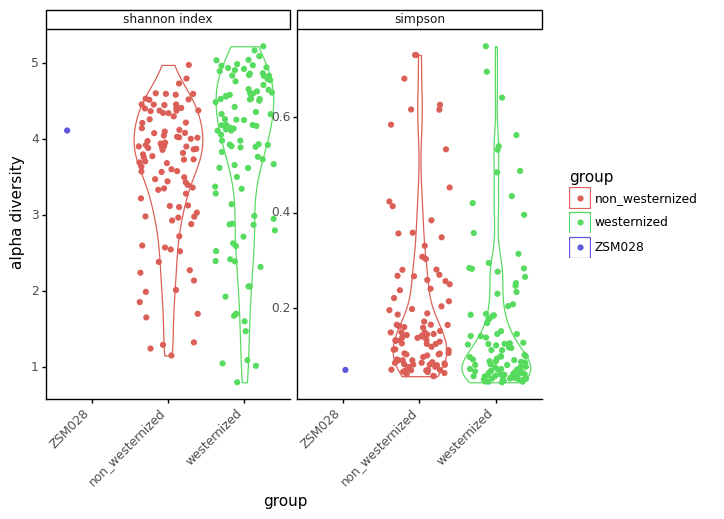

<ggplot: (8771469545156)>

In [179]:
g = ggplot(alpha_diversity, aes(x='group', y='alpha diversity', color='group'))  
g += geom_violin() 
g += geom_jitter() 
g += theme_classic() 
g += facet_wrap('~index', scales = 'free')
g += theme(axis_text_x=element_text(rotation=45, hjust=1))
g

Q: **Why do we observe such a big difference for diversity estimation between the shannon and simpson index of diversity**

### 7.2 Beta diversity

The Beta diversity is the measure of diversity between a pair of samples. It is used to compare the diversity between samples and see how they relate.

We will compute the beta diversity using the [bray-curtis](https://en.wikipedia.org/wiki/Bray%E2%80%93Curtis_dissimilarity) dissimilarity

In [193]:
beta_diversity = skbio.diversity.beta_diversity(metric='braycurtis', counts=all_data.transpose(), ids=all_data.columns, validate=True)

We get a distance matrix

In [195]:
print(beta_diversity)

201x201 distance matrix
IDs:
'ZSM028', 'de028ad4-7ae6-11e9-a106-68b59976a384', 'PNP_Main_283', ...
Data:
[[0.         1.         0.9971956  ... 0.99953997 0.8836078  0.97230227]
 [1.         0.         0.99988327 ... 0.99853413 0.994116   0.99877258]
 [0.9971956  0.99988327 0.         ... 0.82311942 0.87202543 0.91363156]
 ...
 [0.99953997 0.99853413 0.82311942 ... 0.         0.84253376 0.76616679]
 [0.8836078  0.994116   0.87202543 ... 0.84253376 0.         0.82409272]
 [0.97230227 0.99877258 0.91363156 ... 0.76616679 0.82409272 0.        ]]


To visualize this distance matrix in a lower dimensional space, we'll use a [PCoA](https://en.wikipedia.org/wiki/Multidimensional_scaling#Types), which is is a method very similar to a PCA, but taking a distance matrix as input.

In [197]:
pcoa = skbio.stats.ordination.pcoa(beta_diversity)

/home/maxime_borry/.conda/envs/summer_school_microbiome/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.25395587319247886 and the largest is 10.16329853345028.


In [202]:
pcoa.samples

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC192,PC193,PC194,PC195,PC196,PC197,PC198,PC199,PC200,PC201
ZSM028,0.069169,0.091587,-0.232363,0.111829,0.125252,0.085346,-0.065837,0.016136,0.094419,0.037285,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
de028ad4-7ae6-11e9-a106-68b59976a384,-0.096465,0.149116,-0.195873,0.128505,0.120655,0.129180,-0.101003,0.019693,0.096962,0.043844,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PNP_Main_283,-0.215229,-0.148020,0.112290,0.095222,0.074695,-0.121420,0.049054,-0.050986,-0.004760,-0.010992,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PNP_Validation_55,0.246795,-0.172362,-0.308771,-0.020589,0.025365,-0.122255,0.200644,0.019177,0.031151,0.015205,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
G80275,-0.258564,-0.073792,-0.254769,-0.076492,0.083510,-0.165703,0.009076,0.032725,0.006728,-0.020076,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KHG_9,0.294423,-0.152492,0.016210,0.029591,-0.149127,-0.015399,-0.032726,0.073103,-0.062643,-0.066850,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A48_01_1FE,0.111770,0.027008,0.161188,-0.177837,-0.003040,0.108738,0.054111,0.004026,0.038974,-0.073619,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
KHG_1,-0.098523,0.166615,0.015954,0.074814,-0.406843,0.042176,-0.004555,0.029236,-0.066829,-0.156620,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TZ_81781,0.407824,-0.141471,-0.069704,-0.071531,-0.049954,0.119845,0.073552,-0.059494,0.189308,0.000059,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's look at the variance explained by the first axes by using a scree plot

In [218]:
var_explained = pcoa.proportion_explained[:9].to_frame(name='variance explained').reset_index().rename(columns={'index':'PC'})

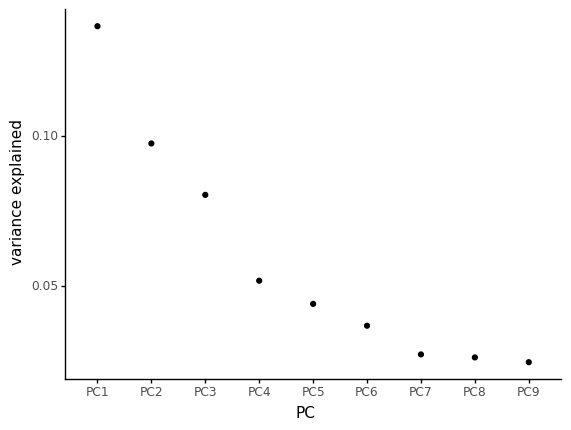

<ggplot: (8771469787037)>

In [220]:
ggplot(var_explained, aes(x='PC', y='variance explained')) + geom_point() + theme_classic()

In [231]:
pcoa_embed = pcoa.samples[['PC1','PC2']].rename_axis('sample').reset_index()

In [232]:
pcoa_embed = (pcoa_embed.merge(metadata[['sample_id', 'non_westernized']], left_on='sample', right_on='sample_id', how='outer')
 .drop('sample_id', axis=1)
 .rename(columns={'non_westernized':'group'}))
pcoa_embed['group'] = pcoa_embed['group'].replace({'yes':'non_westernized','no':'westernized', pd.NA:'ZSM028'})

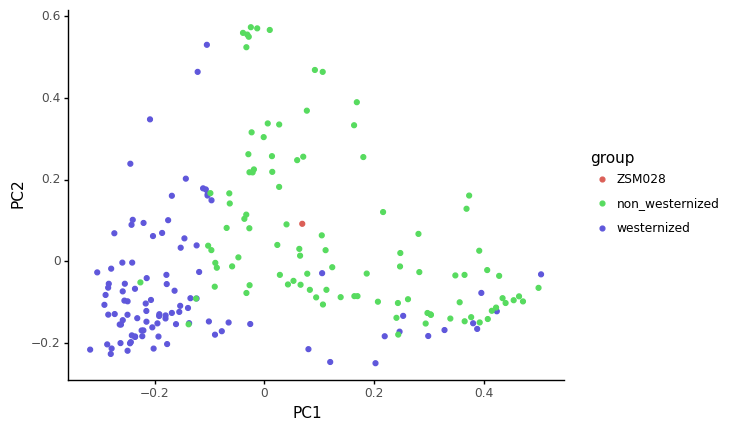

<ggplot: (8771470005185)>

In [234]:
ggplot(pcoa_embed, aes(x='PC1', y='PC2', color='group')) + geom_point() + theme_classic()